<a href="https://www.kaggle.com/code/ayobamimike/medical-imagesdenoisingusingnoise2void?scriptVersionId=223071716" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## This is a PyTorch implementation of a Denoising Autoencoder (DAE) to remove noise from dental X-ray images. The model is trained in an unsupervised manner, meaning it does not require paired clean/noisy images. 

#### The Denoising Autoencoder (DAE) is a neural network-based approach designed to remove noise from dental X-ray images. It is built on a U-Net architecture, which captures fine details and reconstructs clean images from noisy inputs.

#### This implementation processes 120 dental images, extracting useful features while eliminating unwanted noise.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
class NoisyImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = img / 255.0  # Normalize
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dim

        return img, img  # Input = Noisy, Target = Itself (Autoencoder)


In [3]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.decoder(x)
        return x


In [4]:
# Load dataset
dataset = NoisyImageDataset("/kaggle/input/medical-image-dataset/Dataset")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initializing model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for noisy, target in dataloader:
        noisy, target = noisy.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, target)  # This Minimizes noise
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")

# Save model
torch.save(model.state_dict(), "denoising_autoencoder.pth")


Epoch 1/100, Loss: 0.0123
Epoch 2/100, Loss: 0.0013
Epoch 3/100, Loss: 0.0006
Epoch 4/100, Loss: 0.0005
Epoch 5/100, Loss: 0.0004
Epoch 6/100, Loss: 0.0003
Epoch 7/100, Loss: 0.0003
Epoch 8/100, Loss: 0.0003
Epoch 9/100, Loss: 0.0003
Epoch 10/100, Loss: 0.0002
Epoch 11/100, Loss: 0.0002
Epoch 12/100, Loss: 0.0002
Epoch 13/100, Loss: 0.0002
Epoch 14/100, Loss: 0.0002
Epoch 15/100, Loss: 0.0002
Epoch 16/100, Loss: 0.0002
Epoch 17/100, Loss: 0.0002
Epoch 18/100, Loss: 0.0002
Epoch 19/100, Loss: 0.0002
Epoch 20/100, Loss: 0.0002
Epoch 21/100, Loss: 0.0002
Epoch 22/100, Loss: 0.0002
Epoch 23/100, Loss: 0.0001
Epoch 24/100, Loss: 0.0001
Epoch 25/100, Loss: 0.0001
Epoch 26/100, Loss: 0.0003
Epoch 27/100, Loss: 0.0001
Epoch 28/100, Loss: 0.0001
Epoch 29/100, Loss: 0.0001
Epoch 30/100, Loss: 0.0001
Epoch 31/100, Loss: 0.0001
Epoch 32/100, Loss: 0.0001
Epoch 33/100, Loss: 0.0001
Epoch 34/100, Loss: 0.0001
Epoch 35/100, Loss: 0.0001
Epoch 36/100, Loss: 0.0001
Epoch 37/100, Loss: 0.0002
Epoch 38/1

<ipython-input-5-9be12398f8df>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("denoising_autoencoder.pth", map_location=device))


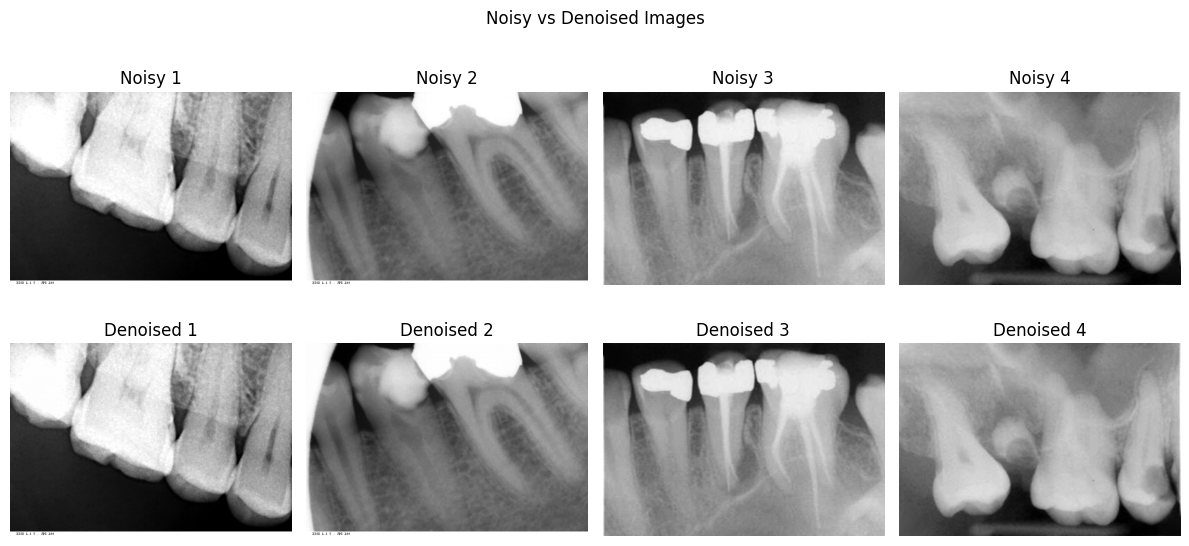

In [5]:
# Model Evaluation
def denoise_image(model, image_path):
    model.eval()
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.0
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        denoised = model(img_tensor).squeeze().cpu().numpy()

    return (denoised * 255).astype(np.uint8)

# Application of the trained model
model.load_state_dict(torch.load("denoising_autoencoder.pth", map_location=device))

# Denoised images saved
input_folder = "/kaggle/input/medical-image-dataset/Dataset"
output_folder = "path/to/denoised_images"
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)

    denoised_img = denoise_image(model, input_path)
    cv2.imwrite(output_path, denoised_img)



noisy_images = sorted(os.listdir(input_folder))[:4]
denoised_images = sorted(os.listdir(output_folder))[:4]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(4):
    # noisy images
    noisy_img = cv2.imread(os.path.join(input_folder, noisy_images[i]), cv2.IMREAD_GRAYSCALE)
    axes[0, i].imshow(noisy_img, cmap='gray')
    axes[0, i].set_title(f"Noisy {i+1}")
    axes[0, i].axis("off")

    # denoised images
    denoised_img = cv2.imread(os.path.join(output_folder, denoised_images[i]), cv2.IMREAD_GRAYSCALE)
    axes[1, i].imshow(denoised_img, cmap='gray')
    axes[1, i].set_title(f"Denoised {i+1}")
    axes[1, i].axis("off")

plt.suptitle("Noisy vs Denoised Images")
plt.tight_layout()
plt.show()